# Problem configuration

In [67]:
%matplotlib inline
import sys
import nibabel as nib
import numpy as np
from scipy import ndimage
from keras import backend as K
from sklearn.metrics import accuracy_score, precision_score
from openpyxl import Workbook, load_workbook

from utils import *
from model_FCNN import generate_model
from segDGM_3DCNN import pipeline_Kvalid


In [2]:
from importlib import reload

import keras
reload(keras)
from keras import backend as K

import utils
reload(utils)
from utils import *

import model_FCNN
reload(model_FCNN)
from model_FCNN import generate_model

import callback_custom
reload(callback_custom);

import segDGM_3DCNN
reload(segDGM_3DCNN)
from segDGM_3DCNN import pipeline_Kvalid


In [23]:
fn_compile = 'results/compile.xlsx'

fn_name_ROI = 'datasets/ROI_name.txt'

fn_output = 'output/iK{}_result.cvs'

In [ ]:
for iK in range(1, 11):
    segDGM_3DCNN.pipeline_Kvalid(iK)

# 4. Compile result

In [27]:
map_name_ROI = {}
with open(fn_name_ROI, 'r') as f:
    for line in f:
        label, name = line.rstrip('\n').split(':')
        name = name.lstrip('\t')
        map_name_ROI[int(label)] = name
        
n_ROI = len(map_name_ROI)

In [91]:
wb =load_workbook(fn_compile)

name_sheet = 'K10_QSM_R2S'
if name_sheet not in wb.get_sheet_names():
    wb.create_sheet(name_sheet)
    
ws = wb.get_sheet_by_name(name_sheet)

ws.cell(column=1, row=1, value='Precision')
ws.cell(column=1, row=15, value='Dice')
for anchor in (1, 15):
    ws.cell(column=1, row=anchor+1, value='ROI Name')
    for label in range(2, 2+10):
        row = anchor + label
        ws.cell(column=1, row=row, value=map_name_ROI[label])

for iK in range(1, 1+10):
    # Write data
    with open(fn_output.format(iK)) as f:
        data = [ list(map(lambda x: float(x) if x != 'N/A' else 0.0, line.rstrip('\n').strip('\t').split('\t')[-n_ROI:])) for line in f ]
        n_test = len(data)//2
        mean_prec = [ sum(x)/n_test for x in zip(*data[:n_test]) ]
        mean_dice = [ sum(x)/n_test for x in zip(*data[n_test:]) ]

    ws.cell(column=iK+1, row=1+1, value='K={}'.format(iK))
    for label in range(2, 2+10):
        row = 1+label
        ws.cell(column=iK+1, row=row, value=mean_prec[label-2])
    
    ws.cell(column=iK+1, row=15+1, value='K={}'.format(iK))
    for label in range(2, 2+10):
        row = 15+label
        ws.cell(column=iK+1, row=row, value=mean_dice[label-2])
    
wb.save(fn_compile)

In [80]:



workbook = xlsxwriter.Workbook(fn_compile)
worksheet = workbook.add_worksheet('K10_QSM_R2S')

bold = workbook.add_format({'bold': True})
form = workbook.add_format({'num_format': '0.000', 'align': 'right'})
align = workbook.add_format({'align': 'right'})


# Write ROI name
worksheet.set_column(0, 0, 20)
worksheet.write(0, 0, 'Precision', bold)
worksheet.write(14, 0, 'Dice', bold)
for anchor in (0, 14):
    worksheet.write(anchor+1, 0, 'ROI Name', bold)
    for label in range(2, 2+10):
        row = anchor+label
        worksheet.write(row, 0, map_name_ROI[label])
    
for iK in range(1, 1+10):
    # Write data
    with open(fn_output.format(iK)) as f:
        data = [ list(map(lambda x: float(x) if x != 'N/A' else 0.0, line.rstrip('\n').strip('\t').split('\t')[-n_ROI:])) for line in f ]
        n_test = len(data)//2
        mean_prec = [ sum(x)/n_test for x in zip(*data[:n_test]) ]
        mean_dice = [ sum(x)/n_test for x in zip(*data[n_test:]) ]

    worksheet.write(1, iK, 'K={}'.format(iK), align)
    for label in range(2, 2+10):
        row = label
        worksheet.write(row, iK, mean_prec[label-2], form)
    
    worksheet.write(14+1, iK, 'K={}'.format(iK), align)
    for label in range(2, 2+10):
        row = 14+label
        worksheet.write(row, iK, mean_dice[label-2], form)

    

workbook.close()

Object `Format` not found.


## 1.2 Pre-processing

In [56]:
## Intensity normalisation (zero mean and unit variance)
input_mean = 127.0
input_std = 64.0#128.0
data_train = (data_train - input_mean) / input_std
data_test = (data_test - input_mean) / input_std

# Map class label
tmp = np.copy(label_train)
for class_idx in class_mapper:
    label_train[tmp == class_idx] = class_mapper[class_idx]
tmp = np.copy(label_test)
for class_idx in class_mapper:
    label_test[tmp == class_idx] = class_mapper[class_idx]
del tmp

In [57]:
label_train.max()

10.0

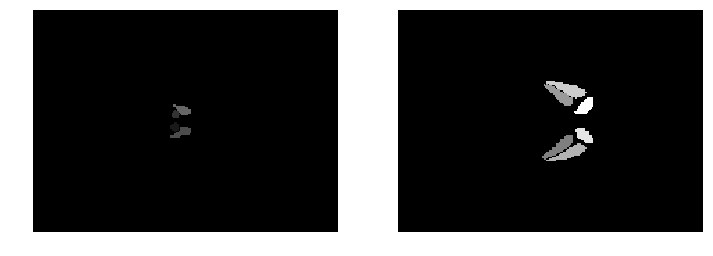

In [58]:
plots(np.squeeze(label_train[0,:,:,[29,25]]), scale = (0, 10))

## 1.3 Data preparation

In [59]:
x_train, y_train = build_set(data_train, label_train, extraction_step, segment_size, core_size)
x_train.shape, y_train.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


((12424, 2, 27, 27, 21), (12424, 243, 11))

In [60]:
# shuffle array
idxs_shuffle = shuffle(x_train)
idxs_shuffle = shuffle(y_train, idxs_shuffle)

## 1.4 Configure callbacks

In [61]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

from callback_custom import EarlyStoppingLowLR
from callback_custom import ReduceLROnPlateauBestWeight



# Model checkpoint to save the training results
checkpointer = ModelCheckpoint(
    filepath=model_filename.format('1'),
    monitor=monitor,
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

# CSVLogger to save the training results in a csv file
csv_logger = CSVLogger(csv_filename.format(1), separator=';')


stopper = EarlyStoppingLowLR(patience=patience, monitor=monitor, thresh_LR=1e-5)

learning_rate_reduction = ReduceLROnPlateauBestWeight(filepath=model_filename.format('1'),
                                                      monitor=monitor, 
                                                      patience=patience, 
                                                      verbose=1, 
                                                      factor=0.1, 
                                                      min_lr=1.001e-5)

callbacks = [checkpointer, csv_logger, learning_rate_reduction, stopper]

## 1.5 Training

In [62]:
seed = 47
np.random.seed(seed)

# Build model
model = generate_model(num_classes, num_channel, segment_size, core_size)

K.set_value(model.optimizer.lr, 1e-3)

model.fit(
    x_train,
    y_train,
    epochs=nb_epoch,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

# freeing space
#del x_train
#del y_train

Train on 11181 samples, validate on 1243 samples
Epoch 1/40
11181/11181 [==============================] - 68s 6ms/step - loss: 0.6807 - categorical_accuracy: 0.7866 - val_loss: 0.4168 - val_categorical_accuracy: 0.8513
Epoch 2/40
11181/11181 [==============================] - 67s 6ms/step - loss: 0.2503 - categorical_accuracy: 0.9104 - val_loss: 0.1901 - val_categorical_accuracy: 0.9275
Epoch 3/40
11181/11181 [==============================] - 67s 6ms/step - loss: 0.1179 - categorical_accuracy: 0.9527 - val_loss: 0.1872 - val_categorical_accuracy: 0.9307
Epoch 4/40
11181/11181 [==============================] - 68s 6ms/step - loss: 0.0910 - categorical_accuracy: 0.9631 - val_loss: 0.2037 - val_categorical_accuracy: 0.9309
Epoch 5/40
11181/11181 [==============================] - 68s 6ms/step - loss: 0.0693 - categorical_accuracy: 0.9716 - val_loss: 0.2162 - val_categorical_accuracy: 0.9368
Epoch 6/40
11181/11181 [==============================] - 69s 6ms/step - loss: 0.0504 - categori

## 1.6 Classification

In [63]:
from keras.models import load_model

# Load best model
model = generate_model(num_classes, num_channel, segment_size, core_size)
model.load_weights(model_filename.format(1))

In [64]:
idx_start_valid = int(len(x_train)*validation_split)
model.evaluate(x_train[-idx_start_valid:], y_train[-idx_start_valid:], verbose=1)

1242/1242 [==============================] - 1s 981us/step


[0.18726991788872582, 0.93065725518885445]

In [65]:
len_patch = extract_patches(read_data(1, 'QSM'), patch_shape=segment_size, extraction_step=(9, 9, 3)).shape[0]
len_patch

3300

In [66]:
segmentations_train = []

for i_case, case_idx in enumerate(idxs_training):

    print(case_idx)
    input_train = data_train[i_case, :, :, :, :]

    x_test = np.zeros((len_patch, num_channel,) + segment_size, dtype=precision_global)
    for i_channel in range(num_channel):
        x_test[:, i_channel, :, :, :] = extract_patches(input_train[i_channel], patch_shape=segment_size, extraction_step=(9, 9, 3))

    pred = model.predict(x_test, verbose=1)
    pred_classes = np.argmax(pred, axis=2)
    pred_classes = pred_classes.reshape((len(pred_classes), 9, 9, 3))
    segmentation = reconstruct_volume(pred_classes, matrix_size)
    
    segmentations_train = segmentations_train + [segmentation]
    
segmentations_train = np.stack(segmentations_train, axis=0)

1
3300/3300 [==============================] - 3s 810us/step
2
3300/3300 [==============================] - 3s 775us/step
3
3300/3300 [==============================] - 3s 775us/step
4
3300/3300 [==============================] - 3s 778us/step
5
3300/3300 [==============================] - 3s 776us/step
6
3300/3300 [==============================] - 3s 782us/step
7
3300/3300 [==============================] - 3s 786us/step
8
3300/3300 [==============================] - 3s 777us/step
9
3300/3300 [==============================] - 3s 788us/step
10
3300/3300 [==============================] - 3s 788us/step
11
3300/3300 [==============================] - 3s 786us/step
12
3300/3300 [==============================] - 3s 786us/step
13
3300/3300 [==============================] - 3s 781us/step
14
3300/3300 [==============================] - 3s 782us/step
15
3300/3300 [==============================] - 3s 785us/step
16
3300/3300 [==============================] - 3s 788us/step
17
3300/3300 [===

In [67]:
segmentations_train.max()

10.0

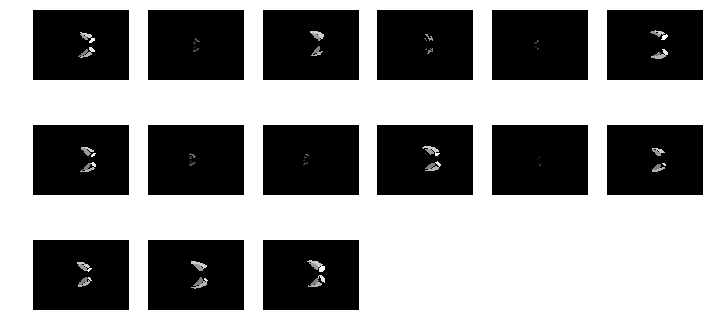

In [68]:
plots(np.squeeze(label_train[0:15,:,:,25]), rows=3, scale = (0, 10))

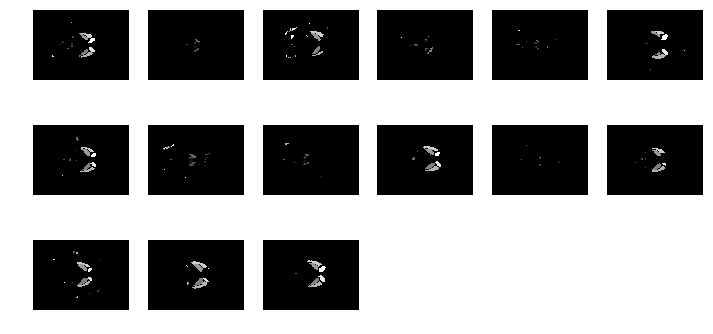

In [69]:
plots(np.squeeze(segmentations_train[0:15,:,:,25]), rows=3, scale = (0, 10))

## 1.7 Check false-positive

In [70]:
idx_fpos = (label_train == 0) & (segmentations_train != 0);

In [71]:
mask_fpos = np.zeros(label_train.shape, dtype=precision_global)
mask_fpos[idx_fpos == True] = 1

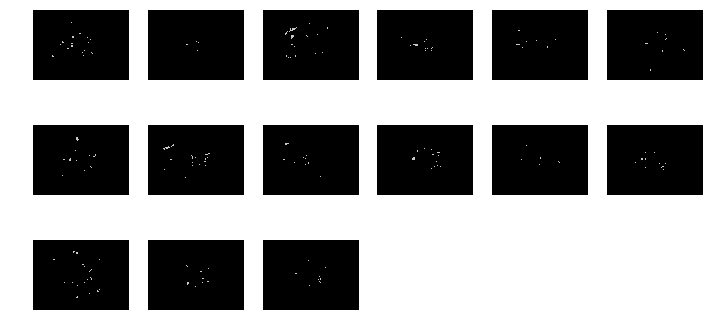

In [72]:
plots(200*(np.squeeze(mask_fpos[0:15,:,:,25])), rows=3)

# 2 Fine-tuning

## 2.2 Rebuild training dataset

In [73]:
del x_train, y_train

In [74]:
#extraction_step_ft = (6,6,3)
x_train, y_train = build_set(data_train, label_train, extraction_step_ft, segment_size, core_size, mask_fpos)
x_train.shape, y_train.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


((9923, 2, 27, 27, 21), (9923, 243, 11))

In [75]:
# shuffle array
#idxs_shuffle = shuffle(x_train)
#idxs_shuffle = shuffle(y_train, idxs_shuffle)

In [76]:
save_array('tmp/x_train.bc', x_train)
save_array('tmp/y_train.bc', y_train)

In [77]:
#x_train = load_array('tmp/x_train.bc')
#y_train = load_array('tmp/y_train.bc')

## 2.3 Regenerate model

In [78]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

from callback_custom import EarlyStoppingLowLR
from callback_custom import ReduceLROnPlateauBestWeight



# Model checkpoint to save the training results
checkpointer = ModelCheckpoint(
    filepath=model_filename.format('2'),
    monitor=monitor,
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

# CSVLogger to save the training results in a csv file
csv_logger = CSVLogger(csv_filename.format(1), separator=';')


stopper = EarlyStoppingLowLR(patience=patience, monitor=monitor, thresh_LR=1e-5)

learning_rate_reduction = ReduceLROnPlateauBestWeight(filepath=model_filename.format('2'),
                                                      monitor=monitor, 
                                                      patience=patience, 
                                                      verbose=1, 
                                                      factor=0.1, 
                                                      min_lr=1.001e-5)

callbacks = [checkpointer, csv_logger, learning_rate_reduction, stopper]

In [79]:
# Build model
model = generate_model(num_classes, num_channel, segment_size, core_size)

# Load optimized weights
model.load_weights(model_filename.format('1'))

K.set_value(model.optimizer.lr, 1e-4)

# Start fine-tuning
model.fit(
    x_train,
    y_train,
    epochs=nb_epoch,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

# freeing space
#del x_train
#del y_train

Train on 8930 samples, validate on 993 samples
Epoch 1/40
8930/8930 [==============================] - 54s 6ms/step - loss: 0.0415 - categorical_accuracy: 0.9835 - val_loss: 0.0074 - val_categorical_accuracy: 0.9969
Epoch 2/40
8930/8930 [==============================] - 53s 6ms/step - loss: 0.0311 - categorical_accuracy: 0.9873 - val_loss: 0.0058 - val_categorical_accuracy: 0.9974
Epoch 3/40
8930/8930 [==============================] - 53s 6ms/step - loss: 0.0270 - categorical_accuracy: 0.9889 - val_loss: 0.0040 - val_categorical_accuracy: 0.9981
Epoch 4/40
8930/8930 [==============================] - 53s 6ms/step - loss: 0.0241 - categorical_accuracy: 0.9901 - val_loss: 0.0032 - val_categorical_accuracy: 0.9986
Epoch 5/40
8930/8930 [==============================] - 53s 6ms/step - loss: 0.0220 - categorical_accuracy: 0.9909 - val_loss: 0.0025 - val_categorical_accuracy: 0.9991
Epoch 6/40
8930/8930 [==============================] - 53s 6ms/step - loss: 0.0198 - categorical_accuracy: 

In [80]:
# Load best model
model = generate_model(num_classes, num_channel, segment_size, core_size)
model.load_weights(model_filename.format('2'))

In [81]:
idx_start_valid = int(len(x_train)*validation_split)
model.evaluate(x_train[-idx_start_valid:], y_train[-idx_start_valid:], verbose=1)

992/992 [==============================] - 1s 954us/step


[0.0020898483061530223, 0.99914107976421229]

In [82]:
segmentations_test = []

for i_case, case_idx in enumerate(idxs_test):

    print(case_idx)
    input_test = data_test[i_case, :, :, :, :]

    x_test = np.zeros((len_patch, num_channel,) + segment_size, dtype=precision_global)
    for i_channel in range(num_channel):
        x_test[:, i_channel, :, :, :] = extract_patches(input_test[i_channel], patch_shape=segment_size, extraction_step=(9, 9, 3))

    pred = model.predict(x_test, verbose=1)
    pred_classes = np.argmax(pred, axis=2)
    pred_classes = pred_classes.reshape((len(pred_classes), 9, 9, 3))
    segmentation = reconstruct_volume(pred_classes, matrix_size)
    #segmentation = reconstruct_volume_majority(pred_classes, matrix_size, extraction_step=(3, 3, 3))
    
    segmentations_test = segmentations_test + [segmentation]
    
segmentations_test = np.stack(segmentations_test, axis=0)

19
3300/3300 [==============================] - 3s 832us/step
20
3300/3300 [==============================] - 3s 787us/step


In [83]:
segmentations_test.max()

10.0

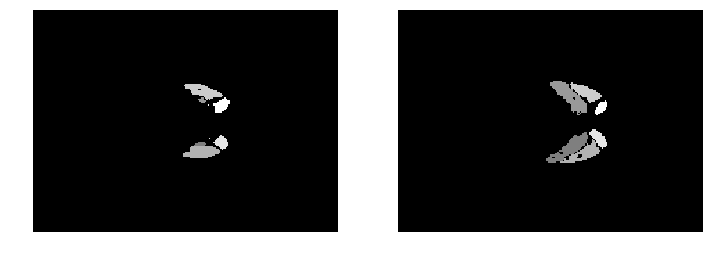

In [84]:
plots(np.squeeze(label_test[:,:,:,23]), rows=1, scale = (0, 10))

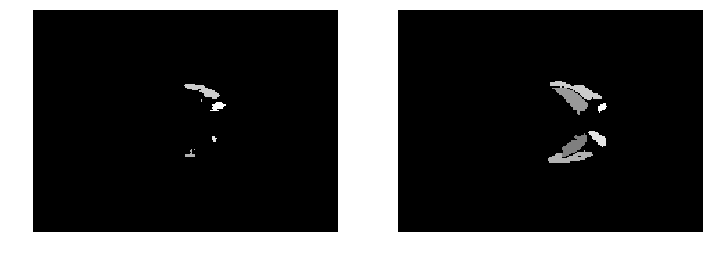

In [85]:
plots(np.squeeze(segmentations_test[:,:,:,23]), rows=1, scale = (0, 10))

# 3 Post-processing

## 3.1 Pick the largest connected component for each class

In [87]:
for i_case, case_idx in enumerate(idxs_test):
    segmentation = np.squeeze(segmentations_test[i_case,:,:,:]);
    tmp = np.zeros(segmentation.shape, dtype=segmentation.dtype)
    
    for class_idx in class_mapper_inv :
        mask = (segmentation == class_idx)
        
        if class_idx != 0 and mask.sum() > 0:
            labeled_mask, num_cc = ndimage.label(mask)
            largest_cc_mask = (labeled_mask == (np.bincount(labeled_mask.flat)[1:].argmax() + 1))
            
            tmp[largest_cc_mask == 1] = class_idx
        
    segmentations_test[i_case,:,:,:] = tmp

## 3.2 Save it 

In [88]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx)
    
    segmentation = np.copy(np.squeeze(segmentations_test[i_case,:,:,:]))
    
    tmp = np.copy(segmentation)
    for class_idx in class_mapper_inv:
        segmentation[tmp == class_idx] = class_mapper_inv[class_idx]
    del tmp

    save_data(segmentation, case_idx, 'label')    

print("Done with Step 3")

19
20
Done with Step 3


## 3.3 Calculate metric 

In [104]:
orig_stdout = sys.stdout
f = open(output_filename, 'w')
sys.stdout = f

In [105]:
def calc_dice(m1, m2):
    return 2*((m1==1) & (m2==1)).sum()/((m1==1).sum() + (m2==1).sum())

In [106]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx, end='\t')
    print('{:.4f}'.format(accuracy_score(label_test[i_case,:,:,:].flat, segmentations_test[i_case,:,:,:].flat)), end='\t')
    for class_idx in class_mapper_inv:
        mask = (np.squeeze(segmentations_test[i_case,:,:,:]) == class_idx)
        if class_idx != 0 and mask.sum() > 0:
            print('{:.4f}'.format(precision_score(label_test[i_case,:,:,:][mask], segmentations_test[i_case,:,:,:][mask], average='micro')), end='\t')
        else:
            print('N/A', end='\t')
    print()

In [107]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx, end='\t')
    for class_idx in class_mapper_inv:
        mask = (np.squeeze(segmentations_test[i_case,:,:,:]) == class_idx)
        if class_idx != 0 and mask.sum() > 0:
            print('{:.4f}'.format(calc_dice((label_test[i_case,:,:,:]==class_idx).flat, (segmentations_test[i_case,:,:,:]==class_idx).flat)), end='\t')
        else:
            print(0, end='\t')
    print()

In [108]:
sys.stdout = orig_stdout
f.close()